We choose the number of topics K based on 10-fold cross-validation.

We proceed as follows:

1. Split the data set randomly into 10 folds.

2.1. Estimate the LDA model on the first 9 folds which serve as a training set. Keep the last 80 samples where the chain has converged.

2.2. Estimate perplexity on the 10th fold which serves as a test set. To do that, calculate perplexity for each of the 80 samples, using the formula:

$ Perplexity = exp\left(- \frac{\sum_{d=1}^{D}\sum_{v=1}^{V} n_{d,v} log(\sum_{k=1}^{K} \hat{\theta_{d}^{k}} \hat{\beta_{k}^{v}})}{\sum_{d=1}^{D} N_d}\right)$,

where $n_{d,v}$ is a count of word $v$ in document $d$, and $N_d$ is the number of words in a document $d$. In this formula, $\hat{\beta_{k}^{v}}$ corresponds to the topic distributions from the LDA estimation on the train set. We re-sample $\hat{\theta_{d}^{k}}$ for each of the 80 samples and all the documents in the test set using 20 iterations of Gibbs sampling. The final perplexity for the 10th fold is calculated by averaging over 80 samples.

3. Repeat the second step 9 more times each time changing the fold that serves as a test set.

4. Calculate the final perplexity as the average over 10 folds.

We load the csv file `articles_daily_ts.csv`, where each news article is assigned a day on which market participants can react to it. The file is imported to the data frame `data`.

In [1]:
import os
import pandas as pd
path_to_file = os.getcwd().replace('\\analysis\\analysis_topics', '') + '\\finance data'
data = pd.read_csv(path_to_file + '\\articles_daily_ts.csv', encoding = 'utf-8-sig', sep=';')

data = data.rename(columns = {"dates": "dates_day"})
data.head()

,texts,titles,dates_day,year,month,day
0,Chilean salmon prices see a lift in week 1. Pr...,Chilean salmon prices see a lift in week 1.,2016-01-13,2016,1,13
1,Nasdaq salmon price index up 48% over past thr...,Nasdaq salmon price index up 48% over past thr...,2016-01-13,2016,1,13
2,Great time to be in the seafood industry. Nati...,Great time to be in the seafood industry.,2016-01-18,2016,1,18
3,Fresh = healthy. Fresh translates to healthy i...,Fresh = healthy.,2016-01-18,2016,1,18
4,Shrimp to get social media revamp. The NFI Shr...,Shrimp to get social media revamp.,2016-01-18,2016,1,18


Pre-process the data in the same way as discussed in the notebook `LDA`.

In [2]:
import topicmodels
docsobj = topicmodels.RawDocs(data.texts, "long")
docsobj.token_clean(1)
docsobj.stopword_remove("tokens")
docsobj.words_remove(docsobj.journalist_names)
docsobj.stem()
docsobj.stopword_remove('stems')
docsobj.term_rank("stems")
docsobj.rank_remove("tfidf","stems",docsobj.tfidf_ranking[12500][1])
all_stems = [s for d in docsobj.stems for s in d]
print("number of unique stems = %d" % len(set(all_stems)))
print("number of total stems = %d" % len(all_stems))

number of unique stems = 11666
number of total stems = 804666


Randomly split the data set into 10 equally-sized folds.

In [3]:
from sklearn.model_selection import ShuffleSplit
ss = ShuffleSplit(n_splits=10, test_size=0.10, random_state=0)
indices = list(ss.split(docsobj.stems))

Create two arrays `train` and `test`. Each of the 10 elements of the `train` array is a list of pre-processed documents that serve as a train set in the current iteration of the cross-validation algorithm. 

In [4]:
import numpy as np
train = []
test = []
for s in range(10):
    train.append(np.array(docsobj.stems)[indices[s][0]])
    test.append(np.array(docsobj.stems)[indices[s][1]])    

Run cross-validation algorithm for K in $\{10,20,...,200\}$.

In [5]:
from datetime import datetime
from statistics import mean
import multiprocessing as mp
# Set the number of cores to use
NUM_CORE = mp.cpu_count()-4
startTime = datetime.now()

import cross_val

perplexity_k = []
for k in range(10, 210, 10):
    train_test_data = list(zip(train,test,[k for i in range(10)]))
    if __name__ == "__main__":
        pool = mp.Pool(NUM_CORE)
        perplexity_test = pool.map(cross_val.cross_val, train_test_data) 
        perplexity_k.append(mean(perplexity_test))
        pool.close()
        pool.join()

print(datetime.now()-startTime)

2 days, 6:55:55.564000


Choose an optimal K based on the following graph, where y-axis corresponds to the perplexity values, and x-axis corresponds to the number of topics.

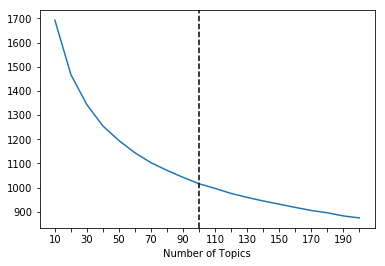

In [6]:
import matplotlib.pyplot as plt
plt.plot(range(len(perplexity_k)), perplexity_k)
plt.xticks(range(len(perplexity_k)), [i if i in range(10,210,20) else '' for i in range(10,210,10)])
plt.axvline(x = 9, color = 'black',  linestyle='dashed')
plt.xlabel('Number of Topics')
plt.show()

In [7]:
np.savetxt("perplexity_k.csv", perplexity_k, delimiter =  ".", fmt='%10.5f')